# Lucas Oliveira Machado de Sousa

**Toy examples**

In this part of the practical session, you will play with some toy data to better understand the classification algorithms seen this morning.

Please answer all questions 

**Deadline**: Upload this notebook, the one about Emotion Recognition and the answers to the theoretical questions to E-Campus. Please verify the exact deadline on E-Campus.

Let's first load the needed packages.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  # for plots
from matplotlib.colors import ListedColormap
from matplotlib import rc

import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import time

%matplotlib inline
np.random.seed(seed=666)

Here, we define some functions useful for generating and plotting the data

In [2]:
def gaussian_data_generation(n, mean, cov, noise_std):
   # create data which follows a multivariate Gaussian distribution
   # a white (Gaussian) noise is then added to the data
    
    assert cov.shape[0] == cov.shape[1], "Please use only square covariance matrix"    
    assert len(mean) == cov.shape[0], "the dimension of the mean should be equal to the dimension of the covariance matrix"
    
    X = np.random.multivariate_normal(mean, cov, n) # actual data
    X = X + np.random.multivariate_normal(np.zeros(len(mean)), noise_std ** 2 *np.eye(len(mean)), n)  # we add white noise to the data     
   
    return X

def frontiere(f, X, y, step=50):
    # decision boundary of classifier f
    # construct cmap

    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", alpha=0.80, cmap=my_cmap)

    ax = plt.gca()
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    for i, label in enumerate(y):
        plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                    s=80, marker=symlist[int(label)])
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    
def class_int_round(z, n_class):
    # rounding needed to go from real to integer values 
    output = np.round(z).astype(int)
    if isinstance(z, np.ndarray):
        j = z < 0
        output[j] = 0
        k = z > n_class - 1
        output[k] = n_class - 1
    else:
        if output < 0:
            output = 0
        else:
            if output > n_class - 1:
                output = n_class - 1
    return output

The next function is the one you will use to crete the toy data. You can choose among three scenarios: 2, 3 or 4 classes. Each class is composed of 2D points sampled from a multivariate Gaussian distribution. You can choose the number of samples, average and covariance matrix for each class. 

In [3]:
def generate_scenario(n_classes=3):
    
    if n_classes == 2:
        # Example with 2 classes
        n_0=80
        mean_0 = [0, 0]        
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)
        
        n_1=80
        mean_1 = [3, 2]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)
        
        X=np.concatenate((X_0,X_1))
        y=np.concatenate((y_0,y_1))
        
    elif n_classes == 3:
        # Example with 3 classes
        n_0=80
        mean_0 = [0, 0]        
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)
        
        n_1=80
        mean_1 = [2, 2]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)
        
        n_2=80
        mean_2 = [3, 3]
        cov_2 = np.array([[0.5, 0.1], [0.1, 1]])
        X_2=gaussian_data_generation(n_2, mean_2, cov_2, 0.1)
        y_2=2*np.ones(n_2)
        
        X=np.concatenate((X_0,X_1,X_2))
        y=np.concatenate((y_0,y_1,y_2))
    elif n_classes == 4:
        # Example with 4 classes
        n_0=80
        mean_0 = [0, 0]        
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)
        
        n_1=80
        mean_1 = [3, 3]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)
        
        n_2=80
        mean_2 = [0, 3]
        cov_2 = np.array([[0.5, 0.1], [0.1, 1]])
        X_2=gaussian_data_generation(n_2, mean_2, cov_2, 0.1)
        y_2=2*np.ones(n_2)
        
        n_3=80
        mean_3 = [3, 0]
        cov_3 = np.array([[0.9, 0.15], [0.15, 0.8]])
        X_3=gaussian_data_generation(n_3, mean_3, cov_3, 0.1)
        y_3=3*np.ones(n_3)
        
        X=np.concatenate((X_0,X_1,X_2,X_3))
        y=np.concatenate((y_0,y_1,y_2,y_3))  

    return X, y

Let's choose a scenario and generate some data

In [8]:
######## PARAMETER TO CHOOSE THE SCENARIO (number of classes) #######
n_classes=4
#####################################################################

X, y = generate_scenario(n_classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Let's plot the data

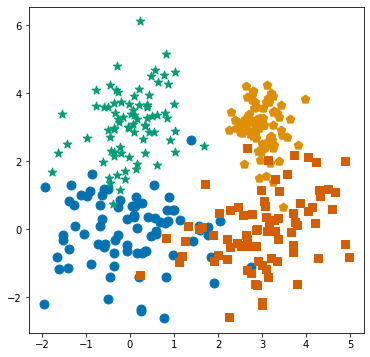

In [9]:
fig1 = plt.figure(figsize=(6, 6))
ax = plt.gca()
min_tot = np.min(X)
max_tot = np.max(X)
symlist = ['o', 'p', '*', 's', '+', 'x', 'D', 'v', '-', '^']
k = np.unique(y).shape[0]
color_blind_list = sns.color_palette("colorblind", k)
for i, label in enumerate(y):
    plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                s=80, marker=symlist[int(label)])
#ax.get_yaxis().set_ticks([])
#ax.get_xaxis().set_ticks([])

As first classifier, we can use a simple linear regression where we  transform in integers the predictions.

 **Question**: look at the function 'class_int_round'. Explain what it does.

**Answer:** This functins receives as parameters an array z (or a single number) with the results of the regression problem and the number of classes, and it'll perform a rounding of the regression values obtained to transform the results of the regression problems into classes labels. It deals with the extreme cases z < 0 or z > #classes by assigning 0 or #classes-1, respectively, to these outputs.

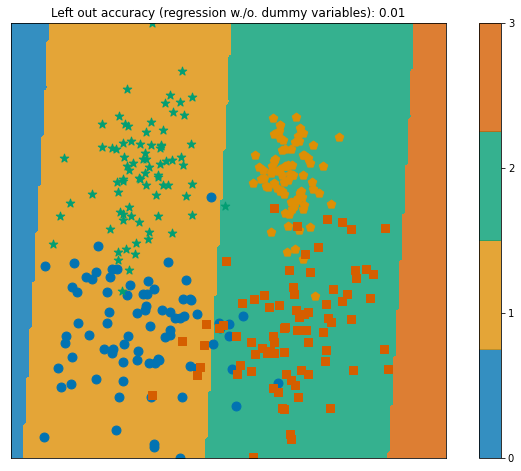

In [11]:
##############################################################################
# Naive linear regression on raw observations
##############################################################################

resolution_param = 150  # 500 for nice plotting, 50 for fast version
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred_test = class_int_round(regr.predict(X_test), n_classes)

# Plotting part
fig0 = plt.figure(figsize=(12, 8))
title = "Left out accuracy (regression w./o. dummy variables)" + \
        ": {:.2f}".format(accuracy_score(y_test, y_pred_test))
plt.title(title)

def f(xx):
    """Classifier"""
    return class_int_round(regr.predict(xx.reshape(1, -1)), n_classes)
frontiere(f, X, y, step=resolution_param)

plt.show()

Instead of using this simple strategy, we can also use a *OneHotEncoder*.

**Question**: Do you see any difference in the resulting decision boundaries ? Which is the best strategy in your opinion ? Why ?

**Answer:** Yes, in the previous classification the boundaries were parallel lines while with the oneHotEncoder the lines intersect. Therefore, for 2 classes the result is similar, for 3 classes rounding is better, and for 4 classes in this case the rounding doesn't work. 

The one hot encoder is generally a better strategy, since the class rounding suits only a few specific problems where the data can be divided by parallel lines.

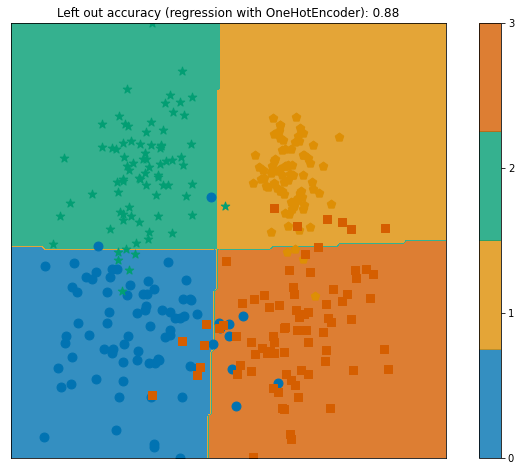

In [10]:
##############################################################################
# Naive linear regression on dummy variables (OneHotEncoder)
##############################################################################
resolution_param = 150  
enc = OneHotEncoder(categories='auto')
enc.fit(y_train.reshape(-1, 1))
Y = enc.transform(y_train.reshape(-1, 1)).toarray()
regr_multi = LinearRegression()
regr_multi.fit(X_train, Y)
proba_vector_test = regr_multi.predict(X_test)
y_pred_test = class_int_round(regr.predict(X_test), n_classes)

# performance evaluation on new dataset
y_pred_test = np.argmax(proba_vector_test, axis=1)
title = "Left out accuracy (regression with OneHotEncoder)" + \
        ": {:.2f}".format(accuracy_score(y_test, y_pred_test))

# Plotting part
fig1 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return np.argmax(regr_multi.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

Let's use the other strategies seen this morning.

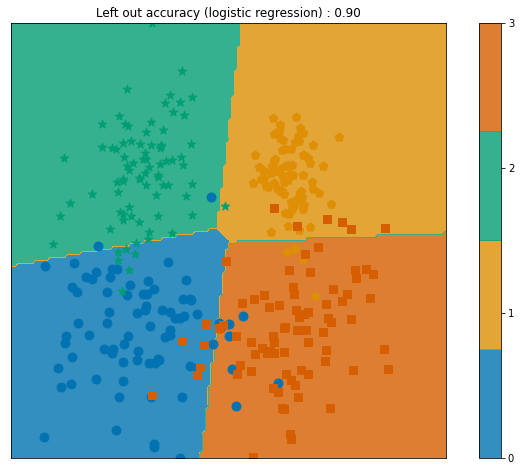

In [12]:
##############################################################################
# Logistic regression
##############################################################################
resolution_param = 150  
clf = LogisticRegression(solver='lbfgs',multi_class='ovr') # you can also try multi_class='multinomial', 
clf.fit(X_train, y_train)
y_logit_test = clf.predict(X_test)
title = "Left out accuracy (logistic regression) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_logit_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

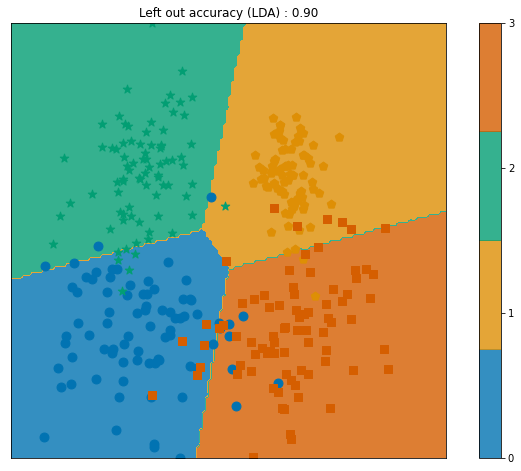

In [13]:
##############################################################################
# LDA
##############################################################################
resolution_param = 150  
clf_LDA = LinearDiscriminantAnalysis()
clf_LDA.fit(X_train, y_train)
y_LDA_test = clf_LDA.predict(X_test)

title = "Left out accuracy (LDA) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_LDA_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_LDA.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

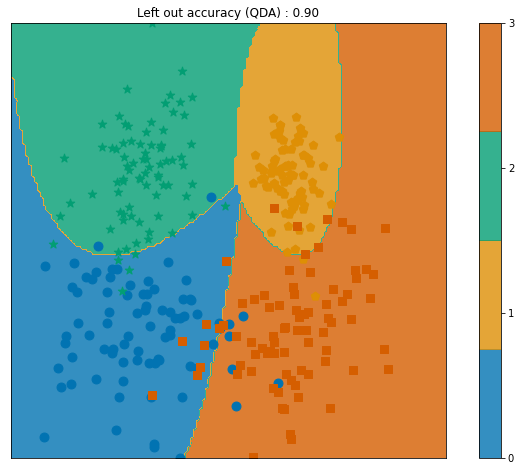

In [14]:
##############################################################################
# QDA
##############################################################################
resolution_param = 150 
clf_QDA = QuadraticDiscriminantAnalysis()
clf_QDA.fit(X_train, y_train)
y_QDA_test = clf_QDA.predict(X_test)
title = "Left out accuracy (QDA) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_QDA_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_QDA.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

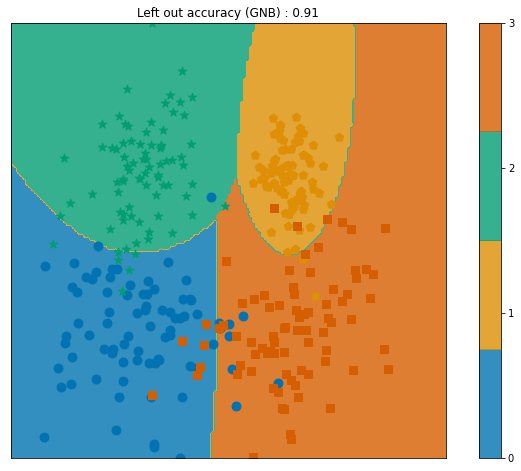

In [15]:
##############################################################################
# Naive Bayes 
##############################################################################
resolution_param = 150  
clf_GNB = GaussianNB()
clf_GNB.fit(X_train, y_train)

y_test_GNB = clf_GNB.predict(X_test)

title = "Left out accuracy (GNB) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_test_GNB))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_GNB.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

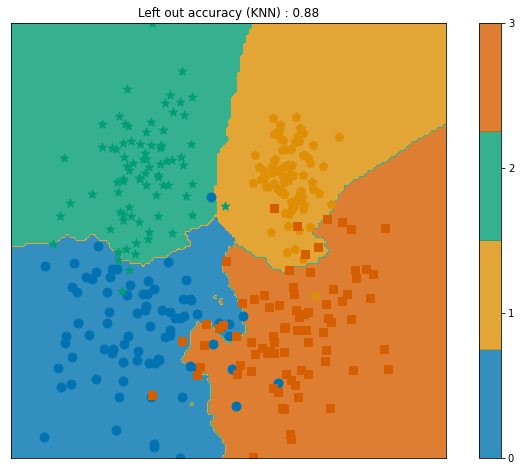

In [16]:
##############################################################################
# KNN
##############################################################################
resolution_param = 150  
clf_KNN = KNeighborsClassifier()
clf_KNN.n_neighbors=5

clf_KNN.fit(X_train, y_train)
y_KNN_test = clf_KNN.predict(X_test)

title = "Left out accuracy (KNN) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_KNN_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)

def f(xx):
    """Classifier"""
    return int(clf_KNN.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

**Questions**:


*   Describe the decision boundaries of the methods. Are all linear ?
*   Using the following code, compare the computational time and the test accuracy of the different methods in the three scenarios. Comment the results.
* (Optional) If you change the number of samples per class (both training and test), do the results vary ?



No, not all of them are linear. Logist regression and LDA are linear, while QDA and Naive Bayes are quadratic and KNN is neither. 

We can see below that Logistic Regression tends to be the slowest algorithm between those seen in class, followed by KNN, while the other methods have a comparable computation time. \\
The first case, with two classes, is very simple, and all the algorithms used succeded on the classification task. When the problem gets more complex with more classes, we see GNB and QDA getting better results than the other methods.

In [43]:
n_list=[2, 3, 4]
for n_classes in n_list:
  print("Testing with ", n_classes, "classes\n")
  X, y = generate_scenario(n_classes)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  funcs = [clf, clf_LDA, clf_QDA, clf_GNB, clf_KNN]
  funcsFit = [clf.predict, clf_LDA.predict, clf_QDA.predict, clf_GNB.predict, clf_KNN.predict]
  funcsPredict = [clf.fit, clf_LDA.fit, clf_QDA.fit, clf_GNB.fit, clf_KNN.fit]
  funcNames = ["Logistic Regression", "Linear Discriminant Analysis", "Quadratic Discriminant Analysis", "Naive Bayes", "K Nearest Neighbours"]

  for i in range(len(funcNames)):
    time_start = time.perf_counter()
    funcs[i].fit(X_train, y_train)
    y_method_test = funcs[i].predict(X_test)
    time_elapsed = (time.perf_counter() - time_start)
    print('Computational time:', "%.6f" %time_elapsed, 's ; Test accuracy ' + funcNames[i], "%.2f" %accuracy_score(y_test, y_method_test))
  print("\n")


Testing with  2 classes

Computational time: 0.004487 s ; Test accuracy Logistic Regression 1.00
Computational time: 0.001955 s ; Test accuracy Linear Discriminant Analysis 0.97
Computational time: 0.002828 s ; Test accuracy Quadratic Discriminant Analysis 1.00
Computational time: 0.002392 s ; Test accuracy Naive Bayes 1.00
Computational time: 0.004458 s ; Test accuracy K Nearest Neighbours 1.00


Testing with  3 classes

Computational time: 0.010692 s ; Test accuracy Logistic Regression 0.90
Computational time: 0.002643 s ; Test accuracy Linear Discriminant Analysis 0.90
Computational time: 0.002743 s ; Test accuracy Quadratic Discriminant Analysis 0.93
Computational time: 0.002606 s ; Test accuracy Naive Bayes 0.93
Computational time: 0.007160 s ; Test accuracy K Nearest Neighbours 0.93


Testing with  4 classes

Computational time: 0.013676 s ; Test accuracy Logistic Regression 0.97
Computational time: 0.002127 s ; Test accuracy Linear Discriminant Analysis 0.97
Computational time: 